# Parte 1 - Implementação de problema de FBA
## 1. Qual é a produção de lactato da estirpe selvagem?

Para avaliar a produção de lactato foi primeiro necessário definir as condições ambientes e obter a função objetivo.
As condições ambientais foram definidas como o consumo de oxigénio de 0 mmol/gDW/h e cosumo de glicose de 15 mmol/gDW/h.
Foi depois obtida a função objetivo (declaração matemática do que deve ser realizado), neste caso para a produção ótima do composto desejado.
Verificou-se que nas condições especificados não existe produção de lactato, ou seja, são produzidos 0 mm/gDW/h de lactato..

In [8]:
from reframed.io.sbml import load_cbmodel
reframed_model = load_cbmodel('../models/iML1515.xml')

from mewpy.simulation import get_simulator
simul = get_simulator(reframed_model)

envcond = {'R_EX_glc__D_e': (-15, 1000), 'R_EX_o2_e': (0, 1000)}

simul = get_simulator(reframed_model, envcond=envcond)
print(simul)
result = simul.simulate(method='FBA')
print(result)

dt = result.fluxes

production = 0
for i in dt:
    if i == 'R_EX_lac__L_e' or i == 'R_EX_lac__D_e':
        production += dt[i]

print("A produção de lactato para as condições ambientais de Oxigénio = 0 mmol/gDW/h e Glicose = 15 mmol/gDW/h é: {0} mmol/gDW/h.".format(production))

objective: 0.26609812519117976
Status: OPTIMAL
A produção de lactato para as condições ambientais de Oxigénio = 0 mmol/gDW/h e Glicose = 15 mmol/gDW/h é: 0.0 mmol/gDW/h.


/home/dm/anaconda3/envs/bs/lib/python3.7/site-packages/reframed/io/sbml.py:510: UserWarning:

Gene association for reaction R_PFL is not DNF

/home/dm/anaconda3/envs/bs/lib/python3.7/site-packages/reframed/io/sbml.py:510: UserWarning:

Gene association for reaction R_RNDR1 is not DNF

/home/dm/anaconda3/envs/bs/lib/python3.7/site-packages/reframed/io/sbml.py:510: UserWarning:

Gene association for reaction R_RNDR3 is not DNF

/home/dm/anaconda3/envs/bs/lib/python3.7/site-packages/reframed/io/sbml.py:510: UserWarning:

Gene association for reaction R_RNDR4 is not DNF

/home/dm/anaconda3/envs/bs/lib/python3.7/site-packages/reframed/io/sbml.py:510: UserWarning:

Gene association for reaction R_CITL is not DNF

/home/dm/anaconda3/envs/bs/lib/python3.7/site-packages/reframed/io/sbml.py:510: UserWarning:

Gene association for reaction R_NO3R1bpp is not DNF

/home/dm/anaconda3/envs/bs/lib/python3.7/site-packages/reframed/io/sbml.py:510: UserWarning:

Gene association for reaction R_NO3R2bpp i

## 2. What are the maximum compoundproduction capabilities?

In [2]:
# identificar os metabolitos externos
reframed_model.summary()


# identificar as reações do metabolito pretendido (lactato)
reframed_model.metabolites["M_lac__L_e"]
reframed_model.metabolites["M_lac__D_e"]

# pode calcular-se a produção máxima em wildtype mantendo a função objectivo de maximização do crescimento, usando FVA
simul.FVA(reactions=['R_EX_lac__L_e', 'R_EX_lac__D_e'])
#OU

# podemos alterar a função objectivo para maximização da produção de lactato e depois analisar o fluxo minimo e maximo usando FVA
# não está completo, são duas reações objectivo
simul.objective = {'R_EX_lac__L_e': -1, 'R_EX_lac__D_e': -1}
simul.objective
simul.FVA(reactions=['R_EX_lac__L_e', 'R_EX_lac__D_e'])

Metabolites:
c 1071
e 341
p 465

Reactions:
enzymatic 1476
transport 833
exchange 337
sink 0
other 66


{'R_EX_lac__L_e': [0.0, 1.1141818181817698],
 'R_EX_lac__D_e': [0.0, 12.255999999998616]}

## 3. Use different optimization objective functionsto improve the production of  the compound, considering  that  cells  have  evolved  for  maximum growth.

In [3]:
from mewpy.simulation import get_simulator
import cobra
from cobamp.wrappers import KShortestEFMEnumeratorWrapper
# import escher

# Exercício 1

model_path = '../models/iML1515.xml'
model = cobra.io.read_sbml_model(model_path)
print(model.summary())

envcond = {'EX_glc__D_e': (-15.0, 1000), 'EX_o2_e': (0, 1000)}
simul = get_simulator(model, envcond=envcond)
result = simul.simulate(method='FBA')
print(result)

model_path1 = '../models/iML1515.xml'
model1 = cobra.io.read_sbml_model(model_path1)
print(model1.summary())

envcond = {'EX_glc__D_e': (-15.0, 1000), 'EX_o2_e': (0, 1000)}
simul1 = get_simulator(model1, envcond=envcond)
result1 = simul1.simulate(method='FBA')
print(result1)


# Exercício 3


model_path = '../models/iML1515.xml'
model = cobra.io.read_sbml_model(model_path)

biomass_c = cobra.Metabolite(compartment='c', id='biomass_c', name='Biomass')
biomass_production = cobra.Reaction(id='EX_biomass_e', name='Biomass production', lower_bound=0, upper_bound=1000)

model_biomass = model.copy()
model_biomass.add_metabolites([biomass_c])

model_biomass.reactions.BIOMASS_Ec_iML1515_core_75p37M.add_metabolites({biomass_c: 1})
biomass_production.add_metabolites({biomass_c: -1})

ksefm = KShortestEFMEnumeratorWrapper(
    model=model_biomass,
    non_consumed=['o2_e'],
    consumed=['glc__D_e'],
    produced=['biomass_c', 'lac__D_e', 'lac__L_e'],
    non_produced=[],
    algorithm_type=KShortestEFMEnumeratorWrapper.ALGORITHM_TYPE_POPULATE,
    stop_criteria=100,
    solver='CPLEX'
)

enumerator = ksefm.get_enumerator()

efm_list = []

while len(efm_list) == 0:
    efm_list += next(enumerator)

print(len(efm_list))
print(*efm_list)

# escher_builder = escher.Builder(
#    map_name='e_coli_core.Core metabolism',
#    hide_secondary_metabolites=True,
#    reaction_data=efm_list[0]
# )
# escher_builder.display_in_notebook(js_source='local')


OSError: [Errno The file with 'filename' does not exist, or is not an SBML string. Provide the path to an existing SBML file or a valid SBML string representation: 
%s] iML1515.xml

### 3.a)

In [5]:

import cobra

import pandas
from time import time

from cobra.util.solver import linear_reaction_coefficients

import cobra.test
from cobra.flux_analysis import (single_gene_deletion, single_reaction_deletion, double_gene_deletion, double_reaction_deletion)

cobramo = cobra.io.read_sbml_model('../models/iML1515.xml')

cobramo.objective = {cobramo.reactions.BIOMASS_Ec_iML1515_core_75p37M: -1.0}
cobramo.objective

cobramo.reactions.get_by_id("EX_o2_e").upper_bound = 1000
cobramo.reactions.get_by_id("EX_o2_e").lower_bound = 0
cobramo.reactions.get_by_id("EX_glc__D_e").upper_bound = 1000
cobramo.reactions.get_by_id("EX_glc__D_e").lower_bound = -15

solution = cobramo.optimize()
print('FBA atraves do cobra:', solution)
print('taxa de crescimento antes da maximização da produção do composto:', solution.objective_value)
print('fluxo da reação da biomassa:', solution.fluxes['BIOMASS_Ec_iML1515_core_75p37M'])

cobramo.objective = {cobramo.reactions.EX_lac__L_e: -1.0, cobramo.reactions.EX_lac__D_e: -1.0}
cobramo.objective

solutionopt = cobramo.optimize()
print('FBA atraves do cobra:', solutionopt)
print('taxa de crescimento depois da maximização da produção do composto:', solutionopt.objective_value)
print('fluxo da reação da biomassa:', solutionopt.fluxes['BIOMASS_Ec_iML1515_core_75p37M'])

FBA atraves do cobra: <Solution 0.000 at 0x7f310a27c4d0>
taxa de crescimento antes da maximização da produção do composto: 0.0
fluxo da reação da biomassa: 0.0
FBA atraves do cobra: <Solution 0.000 at 0x7f310a5b8950>
taxa de crescimento depois da maximização da produção do composto: 0.0
fluxo da reação da biomassa: 0.0


4
3
2
1
Running NSGAII
Gen    Eval|     Worst      Best    Median   Average   Std Dev|     Worst      Best    Median   Average   Std Dev|
   0    100|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
   1    200|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
   2    300|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
   3    400|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
   4    500|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
   5    600|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
   6    700|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.000000  0.000000  0.000000  0.000000|
   7    800|  0.000000  0.000000  0.000000  0.000000  0.0

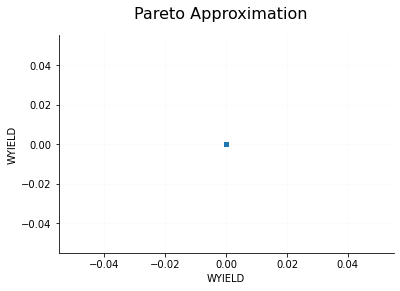

Process ForkPoolWorker-29:


In [11]:
import cobra

import pandas
from time import time

from cobra.util.solver import linear_reaction_coefficients

import cobra.test

model = cobra.io.read_sbml_model('../models/iML1515.xml')

from mewpy.optimization.evaluation import BPCY, TargetFlux, WYIELD, BPCY_FVA
from mewpy.problems import GKOProblem
from mewpy.optimization import EA

print("4")
PRODUCT_ID = 'R_EX_lac__D_e'
BIOMASS_ID = 'R_Biomass_Ec_iML1515_core_75p37M'

envcond = {'R_EX_o2_e'  : (0, 100000.0), 'R_EX_glc__D_e' : (-15, 100000.0)}
print("3")
evaluator_1 = WYIELD(BIOMASS_ID, PRODUCT_ID, alpha=1)
evaluator_2 = WYIELD(BIOMASS_ID, PRODUCT_ID, alpha=0.3)
print("2")
problem = GKOProblem(reframed_model, fevaluation=[evaluator_1, evaluator_2], envcond=envcond, candidate_max_size=1)
print("1")
ea = EA(problem, max_generations= 10, visualizer=True)
final_pop = ea.run()
print(final_pop)